 # Predictiong Stock Market Prices

## Methods Used:
## 1. Moving Average(Mean)
## 2. ARIMA
## 3. LSTM
## 4. IndRnn (New)
## 5. Fine-Tuned IndRnn (New)
# 
# 






## METHOD 1: MOVING AVERAGE
## 1) Predicting Prices Using the Moving Average (MA) method

### LOADING DATA of TATAMOTORS daily Stock market prices from 1996 to 2009 and normalizing it

In [2]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_excel('TATAMOTORS.xlsx')

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-03-06,94.093002,94.859596,93.518097,93.709801,19.893383,122629.0
1,1996-03-07,94.380501,95.817802,93.901398,94.188904,19.995092,297961.0
2,1996-03-08,93.997200,95.721901,93.709801,95.626099,20.300190,389281.0
3,1996-03-09,96.200996,98.308998,96.200996,96.967598,20.584972,712811.0
4,1996-03-10,96.200996,100.609001,96.200996,100.033997,21.235926,870663.0


C:\Users\1864012\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


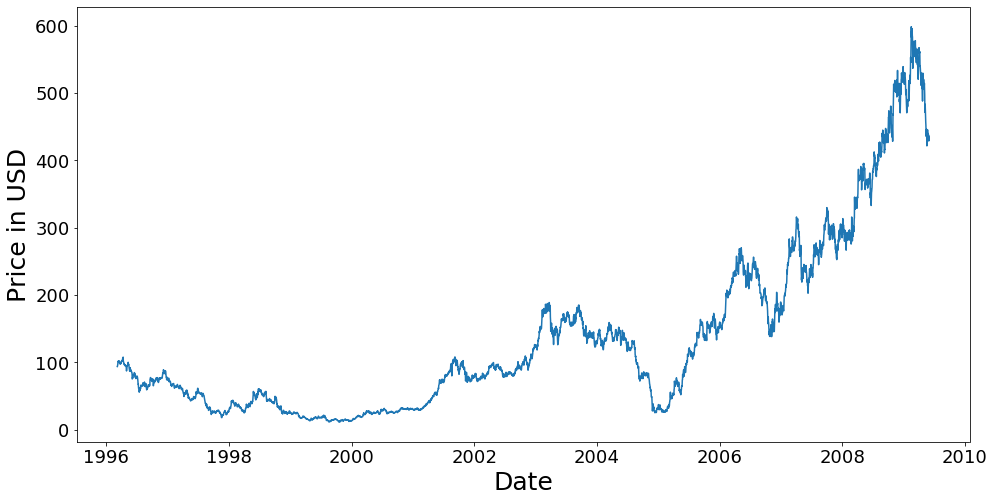

In [3]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%y')
df.index = df['Date']
df.fillna(method='ffill', inplace=True)
#plot the data (close price)
plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=25)
plt.ylabel('Price in USD', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(df['Close'], label='Close Price history')

In [4]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.




### Predicting the close price of the day using MA depending on the prices of the  previous 10 days 

In [5]:
df['10_days_MA'] = np.NaN
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]
window_size = 10
forward_days = 10 # > 1, ou seja, 2,3,4,5,...
for index in range(window_size, len(df), forward_days): #Range(Start, Stop, Step)
    for i in range(0,forward_days):#Range(Start, Stop)
        if index+i >= len(df):
            break
        window_close = make_window(window_size-i, index+i-window_size)
        #print(window_close)
        window_MA = make_window(i, index)
        #print(window_MA)
        mean = pd.concat([ df['Close'].iloc[window_close], df['10_days_MA'].iloc[window_MA] ]).mean(axis=0)
        df.iat[index+i, df.columns.get_loc('10_days_MA')] = mean

        
print("MSE for MA")
print((np.mean((df['Close']-df['10_days_MA'])**2)))

MSE for MA
108.76022415260825


### MSE of Moving Average was 108






### Draw Pridected prices in red and the real prices in blue

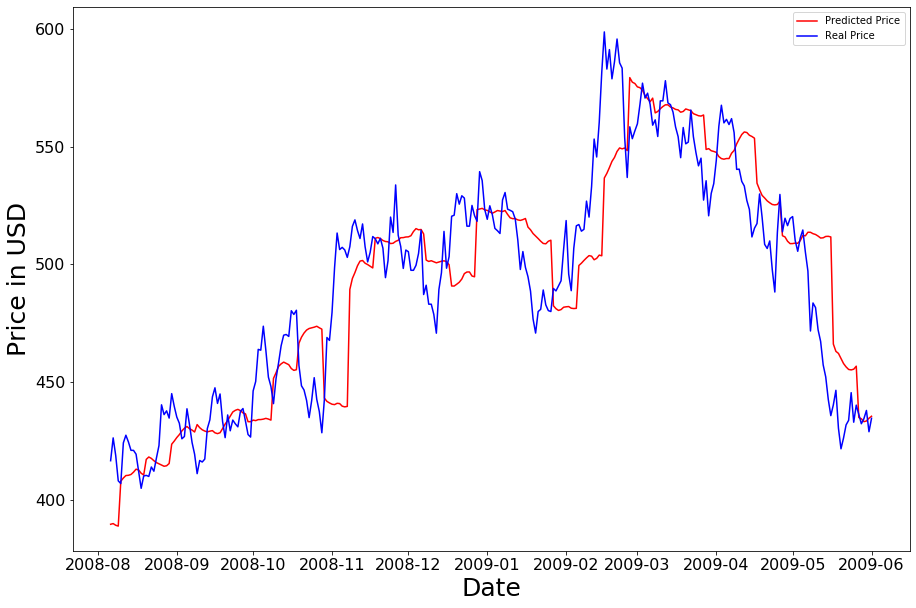

In [6]:
limit=300
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

plt.plot(df['10_days_MA'][-limit:], color='r', label='Predicted Price')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Price in USD', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(df['Close'][-limit:], color='b', label='Real Price')
plt.legend(loc='best')
plt.show()

# 
# 
# 
# 
# 
# 


# 2) Predicting using ARIMA

### ARIMA is an acronym that stands for 'Auto Regressive Integrated Moving Average'. It is a class of model that captures a suite of different standard temporal structures in time series data.


## Load Data

In [8]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams

df = pd.read_excel('TATAMOTORS.xlsx')

#set date as index
df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)
#keep only the 'Close' column
df.fillna(method='ffill', inplace=True)
#df = df['Close']
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-03-06,94.093002,94.859596,93.518097,93.709801,19.893383,122629.0
1,1996-03-07,94.380501,95.817802,93.901398,94.188904,19.995092,297961.0
2,1996-03-08,93.997200,95.721901,93.709801,95.626099,20.300190,389281.0
3,1996-03-09,96.200996,98.308998,96.200996,96.967598,20.584972,712811.0
4,1996-03-10,96.200996,100.609001,96.200996,100.033997,21.235926,870663.0


### Predict with the configurations ARIMA (1,0,0)

In [9]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
            yhat += coef[i-1] * history[-i]
    return yhat

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))


train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    modelarima = ARIMA(history, order=(1,0,0))
    modelarima_fit = modelarima.fit(trend='nc', disp=False)
    ar_coef = modelarima_fit.arparams
    yhat = predict(ar_coef, history)
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('MSE Mean Squared Error for ARIMA: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

dff=test_ar-predictions
dff.max()

<class 'list'>
MSE Mean Squared Error for ARIMA: 55.326
Symmetric mean absolute percentage error: 1.735


31.105198001637234

### MSE of ARIMA was 55

## 